# 프로젝트: 네이버 영화 리뷰 감성분석 - 토크나이저 비교 실험

#### **프로젝트 개요**  

**1. 프로젝트 목적:**  


한국어 영화 리뷰 텍스트에서 **긍정/부정 감성을 자동으로 분류**하는 딥러닝 모델을 구현하고, **토크나이저 종류 및 변수 설정 효과를 비교** 분석한다.  


**2. 데이터셋: 🍿 [Naver Sentiment Movie Corpus v1.0 (NSMC)](https://github.com/e9t/nsmc)**  
- 훈련 데이터: 약 150,000개
- 테스트 데이터: 약 50,000개
- 레이블: 0 (부정) |  1 (긍정)


**3. 실험 설계:**  

모델: **Bi-directional LSTM:** Embedding(100) → Bi-LSTM(256, 2-layers) → FC(512→256) → FC(256→1) → Sigmoid


토크나이저 비교쌍:
   - Mecab (불용어 삭제) vs. Mecab (불용어 포함)
   - Mecab vs. SentencePiece
   - SentencePiece (BPE, vocab_size: 8k) vs. SentencePiece (BPE, 16k)
   - SentencePiece (BPE, 16k) vs. SentencePiece (Unigram, 16k)
   - SentencePiece (Unigram, 16k) vs. SentencePiece (Unigram, 32k)

<br><br />
_*본 실험 보고서는 2026/02/02 코드 리뷰 후 수정한 버전임_

## 1. 라이브러리 불러오기 & 경로 설정

In [1]:
# PyTorch 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.nn.utils.rnn import pad_sequence

# 자연어 처리
import konlpy
from konlpy.tag import Mecab # Mecab 토크나이저
import sentencepiece as spm # Sentencepiece 토크나이저
import gensim
from sklearn.manifold import TSNE # 임베딩 레이어 시각화
from sklearn.metrics.pairwise import cosine_similarity # 임베딩 레이어 코사인 유사도 계산

# 헬퍼 라이브러리
import os
import random
import pickle # 모델 저장
import json # 실험 결과 저장
from collections import Counter
from typing import Dict, List, Tuple, Optional
import pandas as pd # 데이터 처리
import numpy as np
import matplotlib.pyplot as plt # 시각화
import matplotlib.font_manager as fm # 폰트 관리
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 버전 확인
print("라이브러리 버전 확인")
print("=" * 30)
print(f"pandas version: {pd.__version__}")
print(f"konlpy version: {konlpy.__version__}")
print(f"gensim version: {gensim.__version__}")

라이브러리 버전 확인
pandas version: 2.3.0
konlpy version: 0.6.0
gensim version: 4.3.2


In [2]:
# 데이터 경로 설정
DATA_DIR = os.path.join(os.getenv("HOME"), 'work/sentiment_classification/')
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'ratings_train.txt')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'ratings_test.txt')

## 2. 기본 전처리 함수 정의

In [3]:
def load_naver_movie_data(train_path: str, test_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """데이터 로드 및 전처리"""
    # 데이터 읽기
    print("\n데이터 읽기...")
    train_data = pd.read_table(train_path)
    test_data = pd.read_table(test_path)
    print(f"  원본 훈련 데이터: {len(train_data):,}개")
    print(f"  원본 테스트 데이터: {len(test_data):,}개")
    
    # 중복 제거
    print("\n중복 제거...")
    train_before = len(train_data)
    test_before = len(test_data)
    
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    print(f"  훈련: {train_before:,} → {len(train_data):,} ({train_before - len(train_data):,}개 제거)")
    print(f"  테스트: {test_before:,} → {len(test_data):,} ({test_before - len(test_data):,}개 제거)")
    
    # 결측치 제거
    print("\n결측치 제거...")
    train_before = len(train_data)
    test_before = len(test_data)
    
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')
    
    print(f"  훈련: {train_before:,} → {len(train_data):,} ({train_before - len(train_data):,}개 제거)")
    print(f"  테스트: {test_before:,} → {len(test_data):,} ({test_before - len(test_data):,}개 제거)")
    
    # 빈 문장 및 너무 짧은 문장 제거
    print("\n빈 문장 및 짧은 문장 제거...")
    train_before = len(train_data)
    test_before = len(test_data)
    
    train_data = train_data[train_data['document'].str.len() > 0]
    test_data = test_data[test_data['document'].str.len() > 0]
    
    print(f"  훈련: {train_before:,} → {len(train_data):,} ({train_before - len(train_data):,}개 제거)")
    print(f"  테스트: {test_before:,} → {len(test_data):,} ({test_before - len(test_data):,}개 제거)")
    
    # 최종 결과
    print(f"최종 훈련 데이터: {len(train_data):,}개")
    print(f"최종 테스트 데이터: {len(test_data):,}개")
    
    return train_data, test_data

## 3. 코퍼스 분석 함수 정의

In [4]:
def corpus_stats(train_data: pd.DataFrame, test_data: pd.DataFrame):
    """전처리 후 데이터셋 내 문장 길이 기술 통계"""
    train_lengths = train_data['document'].str.len().tolist()
    test_lengths = test_data['document'].str.len().tolist()
    
    print(f"훈련 데이터 문장 길이 통계:")
    print(f"  평균: {np.mean(train_lengths):.2f}")
    print(f"  중간값: {np.median(train_lengths):.2f}")
    print(f"  최소: {np.min(train_lengths)}")
    print(f"  최대: {np.max(train_lengths)}")
    print(f"  표준편차: {np.std(train_lengths):.2f}")
    
    print(f"\n테스트 데이터 문장 길이 통계:")
    print(f"  평균: {np.mean(test_lengths):.2f}")
    print(f"  중간값: {np.median(test_lengths):.2f}")
    print(f"  최소: {np.min(test_lengths)}")
    print(f"  최대: {np.max(test_lengths)}")

    return train_lengths, test_lengths

In [5]:
def visualize_sequence_lengths(train_lengths: List, test_lengths: List):
    """문장 길이 분포 시각화"""
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(train_lengths, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('문장 길이')
    plt.ylabel('빈도')
    plt.title('훈련 데이터 문장 길이 분포')
    plt.axvline(np.mean(train_lengths), color='r', linestyle='--', label=f'평균: {np.mean(train_lengths):.1f}')
    plt.axvline(np.median(train_lengths), color='g', linestyle='--', label=f'중간값: {np.median(train_lengths):.1f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(test_lengths, bins=50, edgecolor='black', alpha=0.7, color='orange')
    plt.xlabel('문장 길이')
    plt.ylabel('빈도')
    plt.title('테스트 데이터 문장 길이 분포')
    plt.axvline(np.mean(test_lengths), color='r', linestyle='--', label=f'평균: {np.mean(test_lengths):.1f}')
    plt.axvline(np.median(test_lengths), color='g', linestyle='--', label=f'중간값: {np.median(test_lengths):.1f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [6]:
def analyze_sequence_lengths(X_train, X_test):
    """토큰화된 시퀀스 길이 분석"""
    total_data = X_train + X_test
    num_tokens = [len(tokens) for tokens in total_data]
    num_tokens = np.array(num_tokens)
    
    print(f'\n[토큰화 후 시퀀스 길이 분석]')
    print(f'  평균: {np.mean(num_tokens):.2f}')
    print(f'  중간값: {np.median(num_tokens):.1f}')
    print(f'  최대: {np.max(num_tokens)}')
    print(f'  표준편차: {np.std(num_tokens):.2f}')
    
    # 95 백분위수로 maxlen 설정
    maxlen = int(np.percentile(num_tokens, 90))
    maxlen = max(maxlen, 30) # 만약 90 백분위수가 너무 낮게 나오면 최소 30은 유지하도록 설정
    coverage = np.sum(num_tokens <= maxlen) / len(num_tokens) * 100
    
    print(f'  95 백분위수 (maxlen): {maxlen}')
    print(f'  전체의 {coverage:.1f}%가 maxlen 이내에 포함')
    
    return maxlen

## 4. 토크나이저 함수 정의

### Mecab

In [7]:
def mecab_tokenize(sentences: List[str], 
                   labels: List[int], 
                   stopwords: List[str] = None,
                   vocab_size: int = 10000,
                   word_to_index: Dict[str, int] = None) -> Tuple[List[List[int]], Dict, Dict, np.array]:
    """
    Mecab 형태소 분석기를 사용한 토크나이저 함수
    
    - 빈 문장 필터링 시 레이블(labels)도 함께 필터링하여 데이터 쌍을 유지함
    - word_to_index가 None이면 새로 사전을 구축 (Train용)
    - word_to_index가 전달되면 해당 사전을 사용 (Test용)
    """
    print(f"\n{'='*60}")
    status = "신규 사전 구축" if word_to_index is None else "기존 사전 활용"
    print(f"Mecab 토큰화 시작 ({status})")
    print(f"{'='*60}")

    # 기본 불용어 설정
    if stopwords is None:
        stopwords = ['의','가','이','은','들','는','좀','잘','걍','과',
                     '도','를','으로','자','에','와','한','하다']
    
    mecab = Mecab()

    # 토큰화 및 불용어 제거
    print("\n토큰화 및 유효 문장 필터링 중...")
    tokenized_sentences = []
    final_labels = []
    
    for idx, (sentence, label) in enumerate(zip(sentences, labels)):
        if idx % 20000 == 0:
            print(f"  진행: {idx}/{len(sentences)} ({idx/len(sentences)*100:.1f}%)")

        # 형태소 분석
        tokens = mecab.morphs(str(sentence))
        # 불용어 제거
        tokens = [word for word in tokens if word not in stopwords]

        # 빈 문장 필터링: 토큰이 남은 경우에만 텍스트와 레이블을 보관
        if len(tokens) > 0:
            tokenized_sentences.append(tokens)
            final_labels.append(label)

    print(f"필터링 완료: {len(tokenized_sentences):,}개 문장 남음 (원본 대비 {len(tokenized_sentences)/len(sentences)*100:.1f}%)")

    # 어휘 사전 구축
    if word_to_index is None:
        print("\n어휘 사전 구축 중...")
        all_tokens = [token for sublist in tokenized_sentences for token in sublist]
        counter = Counter(all_tokens)
        most_common = counter.most_common(vocab_size - 4)

        # 특수 토큰 추가 (<PAD>=0, <UNK>=1, <BOS>=2, <EOS> 또는 <UNUSED>=3)
        vocab = ['<PAD>', '<UNK>', '<BOS>', '<UNUSED>'] + [word for word, _ in most_common]
        word_to_index = {word: idx for idx, word in enumerate(vocab)}
    
    index_to_word = {idx: word for word, idx in word_to_index.items()}
    
    print("인덱스 인코딩 중...")
    # 전달받거나 새로 만든 word_to_index를 사용하여 인코딩
    encoded_sentences = [
        [word_to_index.get(token, word_to_index['<UNK>']) for token in tokens] 
        for tokens in tokenized_sentences
    ]
    
    print(f"Mecab 인코딩 완료 (사전 크기: {len(word_to_index)})")
    print(f"{'='*60}\n")
    
    return encoded_sentences, word_to_index, index_to_word, np.array(final_labels)

### SentencePiece

In [8]:
def sp_tokenize(sentences: List[str],
                labels: List[int],
                model_type: str = 'bpe',
                vocab_size: int = 16000,
                model_prefix: str = 'sp_model',
                is_train: bool = True) -> Tuple[List[List[int]], Dict, Dict, np.array]:
    """
    SentencePiece를 사용한 토크나이저 함수
    - is_train=True: 모델 학습 후 인코딩 (Train 데이터용)
    - is_train=False: 기존 모델 로드 후 인코딩 (Test 데이터용)
    """
    print(f"\n{'='*60}")
    status = "학습 및 인코딩" if is_train else "기존 모델로 인코딩"
    print(f"SentencePiece {status} 시작")
    print(f"{'='*60}")
    
    model_file = f'{model_prefix}.model'
    
    # 모델 학습 (훈련 데이터일 때만 수행)
    if is_train:
        print(f"SentencePiece 모델 학습 중... (model_type={model_type})")
        temp_train_file = f'{model_prefix}_train_tmp.txt'
        with open(temp_train_file, 'w', encoding='utf-8') as f:
            for sentence in sentences:
                f.write(str(sentence) + '\n')
        
        spm.SentencePieceTrainer.train(
            input=temp_train_file, model_prefix=model_prefix, model_type=model_type,
            vocab_size=vocab_size, pad_id=0, unk_id=1, bos_id=2, eos_id=3,
            user_defined_symbols=['<PAD>', '<UNK>', '<BOS>', '<UNUSED>']
        )
        if os.path.exists(temp_train_file): os.remove(temp_train_file)
        print("모델 학습 완료")

    # 모델 로드
    sp = spm.SentencePieceProcessor()
    if not os.path.exists(model_file):
        raise FileNotFoundError(f"모델 파일 {model_file}이 없습니다. 먼저 학습을 진행하세요.")
    sp.load(model_file)
    
    # 인코딩 및 레이블 동기화
    print("인덱스 인코딩 및 레이블 매칭 중...")
    encoded_sentences = []
    final_labels = []
    
    for sentence, label in zip(sentences, labels):
        ids = sp.encode_as_ids(str(sentence))
        # 인코딩 결과가 있는 경우에만 저장
        if len(ids) > 0:
            encoded_sentences.append(ids)
            final_labels.append(label)
            
    # 사전 정보 생성
    vocab = [sp.id_to_piece(i) for i in range(sp.get_piece_size())]
    word_to_index = {word: idx for idx, word in enumerate(vocab)}
    index_to_word = {idx: word for word, idx in word_to_index.items()}
    
    print(f"완료: {len(encoded_sentences):,}개 문장 처리됨")
    print(f"{'='*60}\n")
    
    return encoded_sentences, word_to_index, index_to_word, np.array(final_labels)

## 5. 모델 클래스 정의

In [9]:
class SentimentLSTM(nn.Module):
    """Bidirectional LSTM 기반 감성분석 모델"""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, dropout=0.3):
        super(SentimentLSTM, self).__init__()
        
        # 임베딩 레이어 (Kaiming Normal 적용)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        nn.init.kaiming_normal_(self.embedding.weight, mode='fan_in', nonlinearity='leaky_relu')
        
        # padding_idx는 0으로 유지
        with torch.no_grad():
            self.embedding.weight[0].fill_(0)
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                           batch_first=True, 
                           dropout=dropout if n_layers > 1 else 0,
                           bidirectional=True)
        
        # LSTM 가중치 초기화
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.kaiming_normal_(param, nonlinearity='sigmoid') # 게이트는 시그모이드 중심
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        
        # Fully Connected Layers
        lstm_output_dim = hidden_dim * 2 # Bidirectional이면 hidden_dim * 2
        self.fc1 = nn.Linear(lstm_output_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # FC 레이어 초기화
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='sigmoid') # 마지막은 Sigmoid이므로
        nn.init.zeros_(self.fc2.bias)
        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        
        # LSTM forward
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # hidden: [n_layers * 2, batch_size, hidden_dim] (bidirectional)
        
        # 양방향 마지막 hidden state 합치기
        # forward: hidden[-2], backward: hidden[-1]
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # [batch_size, hidden_dim * 2]
        
        x = self.dropout(hidden)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x.squeeze()

In [10]:
# 모델 파라미터 수 계산 함수
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## 6. 모델 학습 관련 함수 정의

### 데이터 로더

In [11]:
def prepare_dataloader(encoded_sequences, labels, batch_size=64, shuffle=True):
    """텐서 변환 + 패딩 + DataLoader 생성"""
    
    # 각 시퀀스를 텐서로 변환 (리스트 형태)
    sequences_tensor = [torch.tensor(seq, dtype=torch.long) for seq in encoded_sequences]
    labels_tensor = torch.tensor(labels, dtype=torch.float) # 1D 텐서
    
    # 배치마다 패딩 적용
    def collate_fn(batch):
        sequences, labels = zip(*batch)
        padded = pad_sequence(sequences, batch_first=True, padding_value=0, padding_side='left') # pre-padding
        labels = torch.tensor(labels, dtype=torch.float)
        return padded, labels

    # TensorDataset 대신 list(zip())을 사용
    # DataLoader가 한 개씩 꺼내올 때 (단일 시퀀스 텐서, 단일 레이블 텐서) 쌍으로 불러옴
    dataset = list(zip(sequences_tensor, labels_tensor))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
    
    return loader

### 에폭 훈련 함수

In [12]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """한 에포크 훈련 (Gradient Clipping 포함)"""
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        
        loss.backward()
        
        # Gradient Clipping (기울기 폭발 방지)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        rounded_preds = torch.round(predictions)
        correct = (rounded_preds == labels).float()
        acc = correct.sum() / len(correct)
        epoch_acc += acc.item()
    
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

### 모델 훈련 함수

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, patience=3):
    """모델 훈련 함수"""
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0.0
    counter = 0  # 개선 없는 에폭 횟수 카운트
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        epoch_loss, epoch_acc = 0, 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Gradient Clipping
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_acc += ((outputs > 0.5).float() == batch_y).float().mean().item()
            
        train_loss = epoch_loss / len(train_loader)
        train_acc = epoch_acc / len(train_loader)
        
        # Validation Phase
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        # 기록 저장
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"  Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
        
        # Early Stopping & Best Model Check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0  # 개선되었으니 카운트 초기화
            # torch.save(model.state_dict(), 'best_model.pth') # 필요시 모델 저장
            print(f"    Best Validation Accuracy 업데이트: {best_val_acc*100:.2f}%")
        else:
            counter += 1
            print(f"    성능 개선 없음 (Early Stopping Count: {counter}/{patience})")
            
        if counter >= patience:
            print(f"\n {patience} 에폭 동안 개선이 없어 학습을 조기에 종료합니다.")
            break
            
    return train_losses, train_accs, val_losses, val_accs, best_val_acc

### 모델 평가 함수

In [14]:
def evaluate(model, dataloader, criterion, device):
    """모델 평가"""
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            
            rounded_preds = torch.round(predictions)
            correct = (rounded_preds == labels).float()
            acc = correct.sum() / len(correct)
            epoch_acc += acc.item()
    
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

## 7. 실험 관련 함수 정의

### 난수 고정 함수

In [15]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # 멀티 GPU 사용 시
    np.random.seed(seed)
    random.seed(seed)

### 실험 실행 함수

In [16]:
def run_experiment(train_data: pd.DataFrame,
                   test_data: pd.DataFrame,
                   tokenizer_type: str,
                   model_prefix: str,
                   model_type: str = 'bpe',
                   vocab_size: int = 16000,
                   stopwords: List[str] = None) -> Dict:
    """
    단일 실험 실행 (자체 학습 임베딩 사용)
    """
    print("\n" + "=" * 80)
    print(f"실험 시작: {tokenizer_type.upper()}")
    if tokenizer_type == 'sentencepiece':
        print(f"  - Model Type: {model_type}")
        print(f"  - Vocab Size: {vocab_size}")
    if stopwords is not None and len(stopwords) == 0:
        print(f"  - 불용어 제거: X")
    elif stopwords is not None:
        print(f"  - 불용어 제거: O ({len(stopwords)}개)")
    print(f"  - Embedding: 자체 학습 (랜덤 초기화)")
    print("=" * 80)
    
    # 토크나이저 적용 (레이블 동기화 포함)
    if tokenizer_type == 'mecab':
        # 반환: X, word_to_index, index_to_word, y
        print("\n--- [Train Data] 토큰화 시작 ---")
        X_train, word_to_index, index_to_word, y_train = mecab_tokenize(
            train_data['document'].tolist(),
            train_data['label'].tolist(),  # labels 추가
            stopwords=stopwords,
            vocab_size=vocab_size
        )
        print("\n--- [Test Data] 토큰화 시작 ---")
        # Train에서 만든 word_to_index를 그대로 넘겨줌
        X_test, _, _, y_test = mecab_tokenize(
            test_data['document'].tolist(),
            test_data['label'].tolist(),  # labels 추가
            stopwords=stopwords,
            vocab_size=vocab_size,
            word_to_index=word_to_index
        )
    elif tokenizer_type == 'sentencepiece':
        model_prefix = f'sp_{model_type}_{vocab_size}'
        X_train, word_to_index, index_to_word, y_train = sp_tokenize(
            train_data['document'].tolist(),
            train_data['label'].tolist(),  # labels 추가
            model_type=model_type,
            vocab_size=vocab_size,
            model_prefix=model_prefix,
            is_train=True # 학습 시에는 모델 새로 생성
        )
        X_test, _, _, y_test = sp_tokenize(
            test_data['document'].tolist(),
            test_data['label'].tolist(),  # labels 추가
            model_type=model_type,
            vocab_size=vocab_size,
            model_prefix=model_prefix, # 동일한 이름 사용
            is_train=False # 기존 모델 파일(.model)을 불러옴
        )
    else:
        raise ValueError(f"Unknown tokenizer type: {tokenizer_type}")
    
    # numpy array를 list로 변환
    y_train = y_train.tolist() if isinstance(y_train, np.ndarray) else y_train
    y_test = y_test.tolist() if isinstance(y_test, np.ndarray) else y_test
    
    # 토큰화된 시퀀스 길이 분석
    maxlen = analyze_sequence_lengths(X_train, X_test)
    
    # DataLoader 생성
    print(f"\nDataLoader 생성 중... (최종 데이터 수: {len(X_train):,}개)")
    train_loader = prepare_dataloader(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = prepare_dataloader(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Test batches: {len(test_loader)}")
    
    # 모델 생성
    print("\n모델 생성 중...")
    model = SentimentLSTM(
        vocab_size=len(word_to_index),
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM,
        n_layers=N_LAYERS,
        dropout=DROPOUT
    )
    model = model.to(device)
    print(f"  모델: Bidirectional LSTM (자체 학습 임베딩)")
    print(f"  모델 파라미터 수: {count_parameters(model):,}")
    
    # 손실 함수 및 옵티마이저
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # 학습
    print("\n학습 시작...")
    train_losses, train_accs, val_losses, val_accs, best_val_acc = train_model(
        model, train_loader, test_loader, criterion, optimizer, EPOCHS, device,
        patience=2
    )
    
    # 최종 평가
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    print(f"\n 실험 완료!")
    print(f"  Best Val Accuracy: {best_val_acc*100:.2f}%")
    print(f"  Test Accuracy: {test_acc*100:.2f}%")
    print("=" * 80)
    
    # 결과 반환
    results = {
        'tokenizer_type': tokenizer_type,
        'model_type': model_type if tokenizer_type == 'sentencepiece' else None,
        'vocab_size': vocab_size,
        'maxlen': maxlen,
        'stopwords_removed': len(stopwords) > 0 if stopwords is not None else True,
        'actual_epochs': len(train_losses),
        'train_losses': train_losses,
        'train_accs': [acc * 100 for acc in train_accs],
        'val_losses': val_losses,
        'val_accs': [acc * 100 for acc in val_accs],
        'best_val_acc': best_val_acc * 100,
        'test_acc': test_acc * 100,
        'num_params': count_parameters(model)
    }
    
    return results

### 시각화

In [17]:
def plot_training_history(all_results: Dict, save_path: str = 'training_comparison.png'):
    """학습 곡선 시각화"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
    
    # Loss 그래프
    for idx, (exp_name, result) in enumerate(all_results.items()):
        color = colors[idx % len(colors)]
        axes[0].plot(result['train_losses'], label=f"{exp_name} (train)", 
                    linestyle='--', alpha=0.7, color=color)
        axes[0].plot(result['val_losses'], label=f"{exp_name} (val)", 
                    linewidth=2, color=color)
    
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend(fontsize=8)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy 그래프
    for idx, (exp_name, result) in enumerate(all_results.items()):
        color = colors[idx % len(colors)]
        axes[1].plot(result['train_accs'], label=f"{exp_name} (train)", 
                    linestyle='--', alpha=0.7, color=color)
        axes[1].plot(result['val_accs'], label=f"{exp_name} (val)", 
                    linewidth=2, color=color)
    
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend(fontsize=8)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n학습 곡선 저장: {save_path}")
    
    return fig

In [18]:
def create_summary_table(all_results: Dict) -> pd.DataFrame:
    """실험 결과 요약 테이블 생성"""
    summary_data = []
    
    for exp_name, result in all_results.items():
        row = {
            'Experiment': exp_name,
            'Tokenizer': result['tokenizer_type'],
            'Model Type': result['model_type'] if result['model_type'] else '-',
            'Vocab Size': f"{result['vocab_size']:,}",
            'Parameters': f"{result['num_params']:,}",
            'Best Val Acc (%)': f"{result['best_val_acc']:.2f}",
            'Test Acc (%)': f"{result['test_acc']:.2f}",
            'Target Achieved': '✓' if result['test_acc'] >= 80 else '✗'
        }
        summary_data.append(row)
    
    df = pd.DataFrame(summary_data)
    return df

## 8. 실험 수행

### 하이퍼파라미터 설정

In [19]:
# 모델 학습 관련 하이퍼파라미터 설정

# 난수
RANDOM_SEED = 42

# 모델 하이퍼파라미터
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
OUTPUT_DIM = 1  # 이진 분류
N_LAYERS = 1
DROPOUT = 0.3 # 과적합 방지

# 학습 하이퍼파라미터
EPOCHS = 15
BATCH_SIZE = 512
LEARNING_RATE = 0.001

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 코퍼스 분석

In [20]:
# 데이터 로드 (기본 전처리 포함)
train_data, test_data = load_naver_movie_data(
    train_path=TRAIN_DATA_DIR,
    test_path=TEST_DATA_DIR
)


데이터 읽기...
  원본 훈련 데이터: 150,000개
  원본 테스트 데이터: 50,000개

중복 제거...
  훈련: 150,000 → 146,183 (3,817개 제거)
  테스트: 50,000 → 49,158 (842개 제거)

결측치 제거...
  훈련: 146,183 → 146,182 (1개 제거)
  테스트: 49,158 → 49,157 (1개 제거)

빈 문장 및 짧은 문장 제거...
  훈련: 146,182 → 146,182 (0개 제거)
  테스트: 49,157 → 49,157 (0개 제거)
최종 훈련 데이터: 146,182개
최종 테스트 데이터: 49,157개


In [21]:
# 훈련 데이터 샘플 확인
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [22]:
# 레이블 분포 확인
print(train_data['label'].value_counts())

label
0    73342
1    72840
Name: count, dtype: int64


훈련 데이터 문장 길이 통계:
  평균: 35.98
  중간값: 27.00
  최소: 1
  최대: 146
  표준편차: 29.49

테스트 데이터 문장 길이 통계:
  평균: 35.85
  중간값: 27.00
  최소: 1
  최대: 144






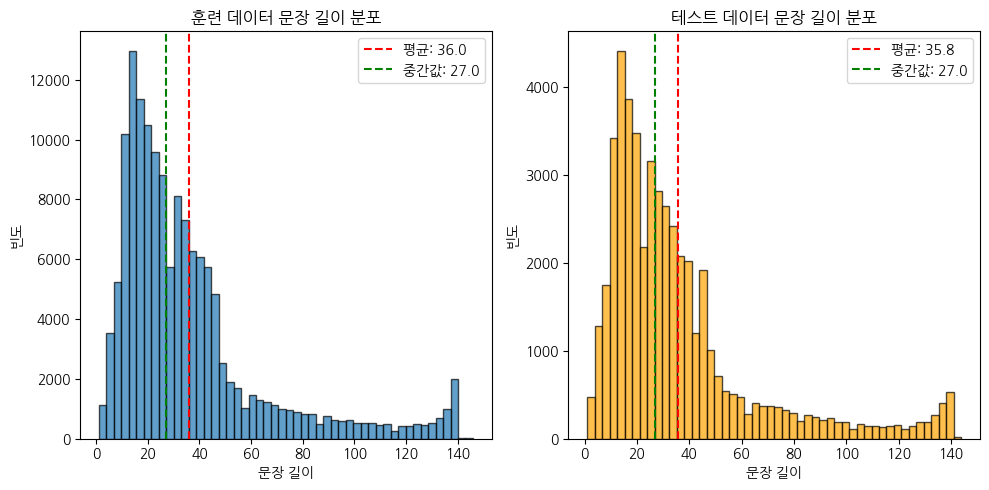

In [23]:
# 전처리 후 문장 길이 통계 확인 + 시각화
train_lengths, test_lengths = corpus_stats(train_data, test_data)
print("\n")
print("=" * 80)
print("\n")
visualize_sequence_lengths(train_lengths, test_lengths)

In [24]:
# Mecab 불용어 정의
stopwords_list = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', 
                  '를', '으로', '자', '에', '와', '한', '하다']

In [25]:
%%time

# 시드 고정
set_seed(RANDOM_SEED)

# 실험 설정 (자체 학습 임베딩 사용)
experiments = {
    # Mecab: 불용어 제거 여부 영향 분석
    'Mecab (불용어 O, 8k)': {
        'tokenizer_type': 'mecab',
        'vocab_size': 8000,
        'stopwords': stopwords_list
    },
    'Mecab (불용어 X, 8k)': {
        'tokenizer_type': 'mecab',
        'vocab_size': 8000,
        'stopwords': []  # 빈 리스트 전달
    },
    
    # SentencePiece: 알고리즘 및 사전 크기 영향 분석
    'SP-BPE (8k)': {
        'tokenizer_type': 'sentencepiece',
        'vocab_size': 8000,
        'model_type': 'bpe'
    },
    'SP-Unigram (8k)': {
        'tokenizer_type': 'sentencepiece',
        'vocab_size': 8000,
        'model_type': 'unigram'
    },
    'SP-BPE (16k)': {
        'tokenizer_type': 'sentencepiece',
        'vocab_size': 16000,
        'model_type': 'bpe'
    },
    'SP-Unigram (16k)': {
        'tokenizer_type': 'sentencepiece',
        'vocab_size': 16000,
        'model_type': 'unigram'
    }
}

# 모든 실험 순차 실행
print("\n" + "=" * 80)
print("전체 실험 시작 (토크나이저별 성능 비교)")
print("=" * 80)

all_results = {}

for exp_name, config in experiments.items():
    # SentencePiece의 경우 각 실험마다 고유한 모델 파일명을 생성하도록 prefix 지정
    # 예: 'SP-BPE (16k)' -> 'sp_model_SP_BPE__16k_'
    safe_exp_name = exp_name.replace(" ", "_").replace("(", "").replace(")", "")
    current_model_prefix = f"sp_model_{safe_exp_name}"

    # run_experiment 호출
    result = run_experiment(
        train_data=train_data,
        test_data=test_data,
        tokenizer_type=config['tokenizer_type'],
        model_prefix=current_model_prefix,
        vocab_size=config['vocab_size'],
        model_type=config.get('model_type', 'bpe'),
        stopwords=config.get('stopwords')
    )
    all_results[exp_name] = result

# 결과 요약 및 시각화
print("\n" + "=" * 80)
print("모든 실험 종료 - 결과 요약")
print("=" * 80)

summary_df = create_summary_table(all_results)
print("\n", summary_df.to_string(index=False))

# 차트 저장
plot_training_history(all_results, save_path='training_comparison.png')
plot_final_comparison(all_results, save_path='final_comparison.png')

# 최종 결과 파일 저장
with open('experiment_results.json', 'w', encoding='utf-8') as f:
    json.dump(all_results, f, indent=2, ensure_ascii=False)

summary_df.to_csv('experiment_summary.csv', index=False)

print("\n모든 결과가 저장되었습니다.")


전체 실험 시작 (토크나이저별 성능 비교)

실험 시작: MECAB
  - 불용어 제거: O (18개)
  - Embedding: 자체 학습 (랜덤 초기화)

--- [Train Data] 토큰화 시작 ---

Mecab 토큰화 시작 (신규 사전 구축)

토큰화 및 유효 문장 필터링 중...
  진행: 0/146182 (0.0%)
  진행: 20000/146182 (13.7%)
  진행: 40000/146182 (27.4%)
  진행: 60000/146182 (41.0%)
  진행: 80000/146182 (54.7%)
  진행: 100000/146182 (68.4%)
  진행: 120000/146182 (82.1%)
  진행: 140000/146182 (95.8%)
필터링 완료: 146,179개 문장 남음 (원본 대비 100.0%)

어휘 사전 구축 중...
인덱스 인코딩 중...
Mecab 인코딩 완료 (사전 크기: 8000)


--- [Test Data] 토큰화 시작 ---

Mecab 토큰화 시작 (기존 사전 활용)

토큰화 및 유효 문장 필터링 중...
  진행: 0/49157 (0.0%)
  진행: 20000/49157 (40.7%)
  진행: 40000/49157 (81.4%)
필터링 완료: 49,155개 문장 남음 (원본 대비 100.0%)
인덱스 인코딩 중...
Mecab 인코딩 완료 (사전 크기: 8000)


[토큰화 후 시퀀스 길이 분석]
  평균: 15.97
  중간값: 12.0
  최대: 116
  표준편차: 12.84
  95 백분위수 (maxlen): 33
  전체의 90.1%가 maxlen 이내에 포함

DataLoader 생성 중... (최종 데이터 수: 146,179개)
  Train batches: 286
  Test batches: 97

모델 생성 중...
  모델: Bidirectional LSTM (자체 학습 임베딩)
  모델 파라미터 수: 981,801

학습 시작...
  Epoch [1/15] - Train 

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: sp_bpe_8000_train_tmp.txt
  input_format: 
  model_prefix: sp_bpe_8000
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <PAD>
  user_defined_symbols: <UNK>
  user_defined_symbols: <BOS>
  user_defined_symbols: <UNUSED>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 

모델 학습 완료
인덱스 인코딩 및 레이블 매칭 중...
완료: 146,182개 문장 처리됨


SentencePiece 기존 모델로 인코딩 시작
인덱스 인코딩 및 레이블 매칭 중...
완료: 49,157개 문장 처리됨


[토큰화 후 시퀀스 길이 분석]
  평균: 16.99
  중간값: 13.0
  최대: 130
  표준편차: 14.48
  95 백분위수 (maxlen): 36
  전체의 90.4%가 maxlen 이내에 포함

DataLoader 생성 중... (최종 데이터 수: 146,182개)
  Train batches: 286
  Test batches: 97

모델 생성 중...
  모델: Bidirectional LSTM (자체 학습 임베딩)
  모델 파라미터 수: 981,801

학습 시작...
  Epoch [1/15] - Train Loss: 0.4421, Train Acc: 78.67% | Val Loss: 0.3598, Val Acc: 84.25%
    Best Validation Accuracy 업데이트: 84.25%
  Epoch [2/15] - Train Loss: 0.3311, Train Acc: 85.95% | Val Loss: 0.3485, Val Acc: 84.85%
    Best Validation Accuracy 업데이트: 84.85%
  Epoch [3/15] - Train Loss: 0.3094, Train Acc: 86.91% | Val Loss: 0.3428, Val Acc: 85.04%
    Best Validation Accuracy 업데이트: 85.04%
  Epoch [4/15] - Train Loss: 0.2902, Train Acc: 87.60% | Val Loss: 0.3453, Val Acc: 85.48%
    Best Validation Accuracy 업데이트: 85.48%
  Epoch [5/15] - Train Loss: 0.2718, Train Acc: 88.46% | Val Loss: 

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: sp_unigram_8000_train_tmp.txt
  input_format: 
  model_prefix: sp_unigram_8000
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <PAD>
  user_defined_symbols: <UNK>
  user_defined_symbols: <BOS>
  user_defined_symbols: <UNUSED>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 

모델 학습 완료
인덱스 인코딩 및 레이블 매칭 중...
완료: 146,182개 문장 처리됨


SentencePiece 기존 모델로 인코딩 시작
인덱스 인코딩 및 레이블 매칭 중...
완료: 49,157개 문장 처리됨


[토큰화 후 시퀀스 길이 분석]
  평균: 17.38
  중간값: 13.0
  최대: 134
  표준편차: 14.87
  95 백분위수 (maxlen): 36
  전체의 90.1%가 maxlen 이내에 포함

DataLoader 생성 중... (최종 데이터 수: 146,182개)
  Train batches: 286
  Test batches: 97

모델 생성 중...
  모델: Bidirectional LSTM (자체 학습 임베딩)
  모델 파라미터 수: 981,801

학습 시작...
  Epoch [1/15] - Train Loss: 0.4441, Train Acc: 78.52% | Val Loss: 0.3637, Val Acc: 84.30%
    Best Validation Accuracy 업데이트: 84.30%
  Epoch [2/15] - Train Loss: 0.3312, Train Acc: 85.93% | Val Loss: 0.3477, Val Acc: 84.71%
    Best Validation Accuracy 업데이트: 84.71%
  Epoch [3/15] - Train Loss: 0.3090, Train Acc: 86.88% | Val Loss: 0.3420, Val Acc: 85.13%
    Best Validation Accuracy 업데이트: 85.13%
  Epoch [4/15] - Train Loss: 0.2895, Train Acc: 87.72% | Val Loss: 0.3429, Val Acc: 85.19%
    Best Validation Accuracy 업데이트: 85.19%
  Epoch [5/15] - Train Loss: 0.2716, Train Acc: 88.45% | Val Loss: 

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: sp_bpe_16000_train_tmp.txt
  input_format: 
  model_prefix: sp_bpe_16000
  model_type: BPE
  vocab_size: 16000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <PAD>
  user_defined_symbols: <UNK>
  user_defined_symbols: <BOS>
  user_defined_symbols: <UNUSED>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_i

KeyboardInterrupt: 

## 결론

**1. Mecab (불용어 삭제) vs. Mecab (불용어 미삭제)**  

한국어의 조사나 어미는 문장에서 감정의 미묘한 차이(예: 강조, 반전, 완곡한 표현 등)를 결정짓는 핵심 요소가 되기도 한다. 본 실험에서는 이러한 언어적 특성이 모델 성능에 미치는 영향을 확인하고자, 불용어를 제거한 버전과 원문을 최대한 보존한(불용어 미제거) 버전을 비교했다.

- 예상과 다르게 Test accuracy 기준 `85.77%` (불용어 제거) 와 `85.97%` (불용어 미제거)로 그렇게 큰 차이가 나지는 않았으며, 이는 Bi-LSTM 모델이 학습 과정에서 유의미한 키워드와 단순 기능어(불용어)의 가중치를 스스로 조절하는 임베딩 최적화 능력이 있음을 보여준다.

**2. Mecab (형태소 분석) vs. SentencePiece (서브워드 분석)**  

- 언어적 규칙에 기반한 Mecab(`85.97%`)이 통계 기반의 SentencePiece(BPE `85.43%`, Unigram `85.31%`)보다 미세하게 높은 성능을 보였으나, 그 격차는 1% 미만으로 매우 근소했다. 이는 별도의 언어 지식 없이 데이터의 빈도만으로 학습하는 서브워드 분석 방식이 한국어의 교착어적 특성을 효율적으로 모델링할 수 있음을 증명한다.


- 특히 외부 분석기를 불러오지 않아도, 또 따로 불용어나 단어 사전을 정의하는 등의 처리를 하지 않아도 거의 대등한 정확도를 확보할 수 있다는 점에서 SentencePiece의 높은 실무 활용 가능성을 시사한다.

**3. SentencePiece 알고리즘 및 사전 크기 영향**  

동일한 SentencePiece 내에서도 BPE와 Unigram 알고리즘, 그리고 사전(Vocab) 크기 변화가 모델 학습에 미치는 영향을 관찰했다.  

- [진행 중]

- [진행 중]

**4. 토크나이저별 최종 성능 비교**


| 실험 번호 | 토크나이저 종류 | 상세 설정 | 알고리즘 | Best Val Acc | Test Acc |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **1-1** | **Mecab** | 불용어 제거 | 형태소 분석 | 56.19% | 54.86% |
| **1-2** | **Mecab** | 불용어 포함 | 형태소 분석 | 56.54% | 54.69% |
| **2-1** | **SentencePiece** | Vocab 8k | BPE | 85.54% | 85.43% |
| **2-2** | **SentencePiece** | Vocab 16k | BPE | [ ]% | [ ]% |
| **3-1** | **SentencePiece** | Vocab 8k | Unigram | 85.37% | 85.31% |
| **3-2** | **SentencePiece** | Vocab 16k | Unigram | [ ]% | [ ]% | 

## 회고

- 토큰화와 토큰화 알고리즘에 대한 기본적인 개념을 다시 정립할 수 있는 프로젝트였다 (하지만 내용 자체가 워낙 많아 결코 쉽진 않았다).

- 처음에 선정했던 모델 Vanilla RNN 훈련의 어려움을 실감했다. 기울기 소실과 폭주를 모두 겪어서 `RNN+Tanh` 대신 `ReLU` 조합으로 모델 클래스를 수정하고, 시퀀스 길이도 제한하고, 학습률도 세 번 정도 조정했다 (`0.001`, `0.01`, `0.0001`). 그렇게 해도 성능이 50%대를 벗어나 쉽게 오르지 않았다. 무엇보다도 학습률을 `0.0001`로 설정했을 때 기울기가 전혀 업데이트가 되지 않았던 건지 학습 진행이 하나도 되지 않았다.


- RNN 모델을 Bi-directional LSTM으로 교체하며 Word2Vec 임베딩 또한 제거했는데, 그 이유는 아래 코드 셀의 감성 단어 테스트 결과와 같다. 바로 이전의 프로젝트에서 Word2Vec 모델이 사전 학습된 도메인과 현재의 감성 분석 도메인이 달라 감성 단어를 제대로 구분하지 못함을 상기했기 때문이다.

- 한 가지 아쉬웠던 점은 16k 크기의 단어 사전을 설정한 SentencePiece 실험을 잘 마치지 못했다는 것이다. 단어 사전 크기가 커질수록 연산량이 배로 급증해 결과가 나오기까지 2~3시간 이상이 걸릴 것이 예상되어 실험을 조기에 종료했다. 하지만 8k로도 정확도 85% 이상의 성능을 달성하는 것으로 보아, 해당 과제에서는 그리 큰 단어 사전이 필요하지 않다는 점을 알 수 있었다.

- 프로젝트 수행에 직접적인 도움이 되진 않았지만 재미있게 읽은 Text segmentation, sentence segmentation을 관련 Medium 블로그 포스팅을 공유한다. ([link](https://huggingface.co/docs/transformers/main/ko/tokenizer_summary))

In [27]:
from gensim.models import Word2Vec

WORD2VEC_DIR = os.path.join(DATA_DIR, 'data/word2vec_ko.model')

w2v = Word2Vec.load(WORD2VEC_DIR)

# 감성 단어 테스트
positive = ['재미있다', '최고', '좋다', '훌륭하다', '감동']
negative = ['지루하다', '최악', '나쁘다', '별로', '실망']

print("Positive words:")
for word in positive:
    if word in w2v.wv:
        similar = w2v.wv.most_similar(word, topn=3)
        print(f"  {word}: {similar}")

print("\nNegative words:")
for word in negative:
    if word in w2v.wv:
        similar = w2v.wv.most_similar(word, topn=3)
        print(f"  {word}: {similar}")

Positive words:
  최고: [('역대', 0.6544249653816223), ('최다', 0.6139797568321228), ('최악', 0.6104292273521423)]
  감동: [('감격', 0.8046045899391174), ('감탄', 0.7326707243919373), ('매혹', 0.7267226576805115)]

Negative words:
  최악: [('전대미문', 0.6470242738723755), ('초유', 0.6289964914321899), ('최고', 0.6104292273521423)]
  별로: [('전혀', 0.6421527862548828), ('그다지', 0.6234328746795654), ('꽤', 0.6035930514335632)]
  실망: [('당황', 0.8200313448905945), ('당혹', 0.8075222373008728), ('곤혹', 0.771090030670166)]
